***
***
***
# Digit Eye
***
***
***
Integrantes:
- Diryon Yonith Mora Romero.
- Laura Valentina Gonzalez Rodriguez.
***
***
***
## Carga de Liberias Utilizadas.

In [1]:
%load_ext autoreload
%autoreload 2
import torch
import torch.utils.data
import torchvision
import torchvision.transforms as transforms
import numpy as np
import pickle
import os

from torch.utils.data import DataLoader, Dataset

from src.models import Cifar10Model, ResNet18_32x32, SimpleNet_32x32
from src.models.common.types import EpochResult
from src.models.common.constants import CUDA_IS_AVAILABLE

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from typing import Dict, List, Tuple
from math import ceil

from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

torch.manual_seed(1)
print("CUDA IS AVAILABLE: ", CUDA_IS_AVAILABLE)

CUDA IS AVAILABLE:  True


***
***
***
## Preparación de los Datos

Este código se encarga de descargar, preparar y organizar los conjuntos de datos de entrenamiento, prueba y validación para su uso en el entrenamiento y evaluación de modelos de aprendizaje automático utilizando la biblioteca PyTorch.

In [2]:
transform_normalization = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
train_transform = transforms.Compose(
    [
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transform_normalization,
    ]
)
test_transform = transforms.Compose([transforms.ToTensor(), transform_normalization])

train_set = torchvision.datasets.CIFAR10(
    root="./assets/data", train=True, download=True, transform=train_transform
)
test_set = torchvision.datasets.CIFAR10(
    root="./assets/data", train=False, download=True, transform=test_transform
)
test_set, validation_set = torch.utils.data.random_split(test_set, (5000, 5000))


batch_size = 128
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=False)
validation_loader = DataLoader(
    dataset=validation_set, batch_size=batch_size, shuffle=False
)

Files already downloaded and verified
Files already downloaded and verified


***
***
***
## Carga de los Modelos
Este código se refiere a la carga de modelos pre-entrenados para la clasificación de imágenes en el conjunto de datos CIFAR-10.


**SimpleNet** es una red neuronal convolucional que utiliza bloques simples con capas convolucionales, funciones de activación ReLU y capas lineales para extraer características de las imágenes y realizar la clasificación en las clases de salida. Es una red sencilla pero eficaz para tareas de clasificación de imágenes.

**ResNet-18** es una red neuronal convolucional diseñada para clasificar imágenes. Utiliza conexiones residuales y bloques básicos para facilitar un entrenamiento más profundo y evitar problemas de desvanecimiento del gradiente. La red extrae características relevantes de las imágenes y las utiliza para realizar la clasificación en las clases de salida.

In [3]:
simple_net_path = "./assets/models/digit_eye_simplenet"
simple_net_model = Cifar10Model(path=simple_net_path, model = SimpleNet_32x32)

res_net_path = "./assets/models/digit_eye_resnet18"
res_net_model = Cifar10Model(path = res_net_path, model = ResNet18_32x32)

***
***
***
## Entrenamiento de los Modelos
Este código proporciona funcionalidades para visualizar el rendimiento de los modelos de clasificación de imágenes en el conjunto de datos CIFAR-10 a lo largo de las épocas de entrenamiento. Permite graficar y analizar las precisiones y pérdidas de entrenamiento y prueba, así como entrenar modelos y guardar el historial de entrenamiento para su posterior uso.

In [4]:
def plot_accuracies(history: list[EpochResult]):
    testing_accuracies = [x["testing"]["accuracy"] for x in history]
    training_accuracies = [x["training"]["accuracy"] for x in history]

    plt.figure()
    plt.plot(training_accuracies, "-rx")
    plt.plot(testing_accuracies, "-bx")

    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.legend(["Training", "Testing"])
    plt.title("Accuracy vs. No of epochs")


def plot_losses(history: list[EpochResult]):
    training_losses = [x["training"]["average_loss"] for x in history]
    testing_losses = [x["testing"]["average_loss"] for x in history]

    plt.figure()
    plt.plot(training_losses, "-rx")
    plt.plot(testing_losses, "-bx")

    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend(["Training", "Testing"])
    plt.title("Loss vs. No of epochs")


def get_history_path(model: Cifar10Model):
    return f"./assets/histories/{type(model.inner_model).__name__}"


def plot_statistics(model: Cifar10Model):
    history_path = get_history_path(model)
    if os.path.isfile(history_path):
        with open(history_path, "rb") as file:
            history: list[EpochResult] = pickle.load(file)
            plot_accuracies(history)
            plot_losses(history)


def train_model(model: Cifar10Model, epochs: int = 20):
    history_path = get_history_path(model)
    history = model.train(
        epochs=epochs, train_loader=train_loader, test_loader=test_loader
    )

    with open(history_path, "wb") as file:
        pickle.dump(history, file)

***
***
## Modelo SimpleNet 

Este código entrena el modelo de red neuronal "simple_net_model" o carga los pesos previamente guardados en el modelo. Finalmente, genera una representación gráfica de las estadísticas de rendimiento del modelo.

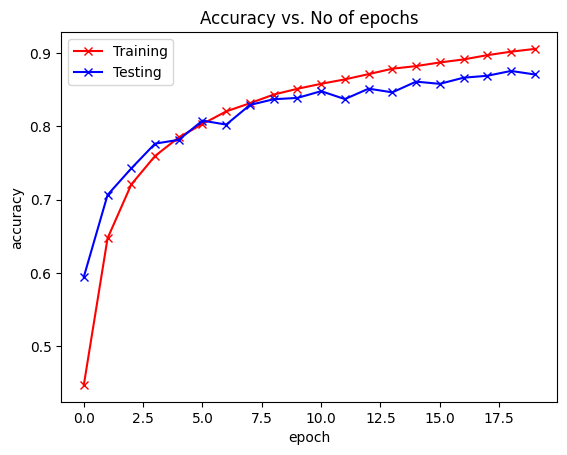

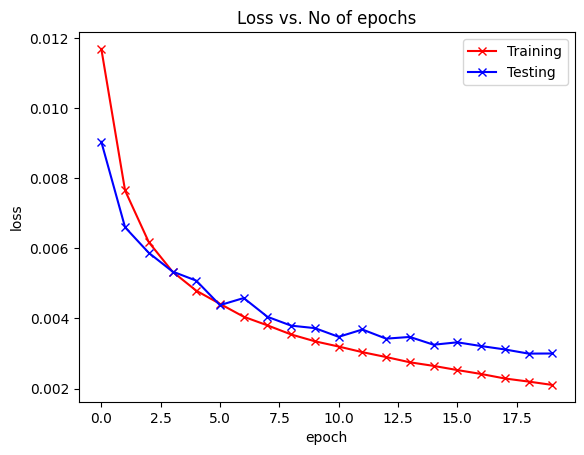

In [5]:
#train_model(simple_net_model)
simple_net_model.load_weights()
plot_statistics(simple_net_model)

***
***
## Modelo ResNet-18

Este código entrena el modelo de red neuronal "res_net_model" o carga los pesos previamente guardados en el modelo. Finalmente, genera una representación gráfica de las estadísticas de rendimiento del modelo.

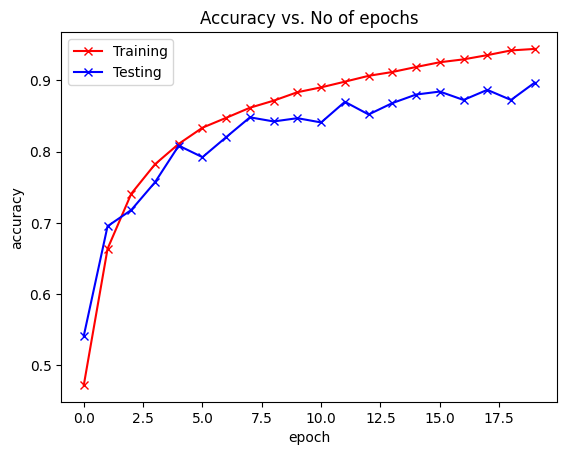

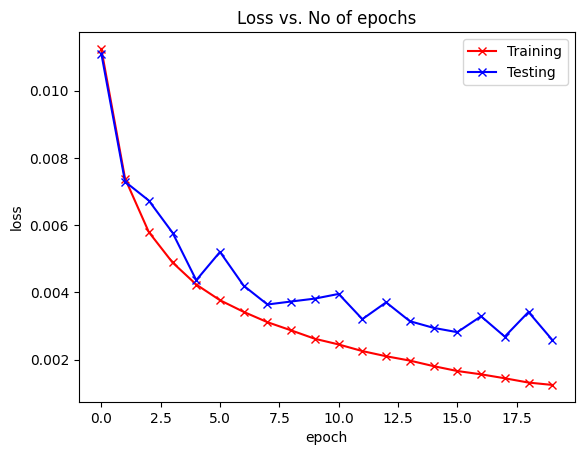

In [6]:
#train_model(res_net_model)
res_net_model.load_weights()
plot_statistics(res_net_model)

***
***
***
## Evaluación de los Modelos

***
***

## Matriz de Dispersión

Este código proporciona funcionalidades para evaluar el rendimiento de un modelo de clasificación de imágenes en el conjunto de datos de validación CIFAR-10. Utiliza la matriz de confusión para mostrar la distribución de las predicciones del modelo en comparación con los valores reales en el conjunto de validación.

In [7]:
def plot_preds(model: Cifar10Model):
    y_pred = []
    y_true = []

    model.inner_model.eval()
    for batch in validation_loader:
        batch_step = model.batch_step(batch)
        y_pred.extend(batch_step["preds"])
        y_true.extend(batch[1].data)

    y_pred = [y.item() for y in y_pred]
    y_true = [y.item() for y in y_true]

    precision = precision_score(y_pred, y_true, average='weighted')
    recall = recall_score(y_pred, y_true, average='weighted')
    f1score = f1_score(y_pred, y_true, average='weighted')

    print(f"Precision = {precision}")
    print(f"Recall = {recall}")
    print(f"F1 Score = {f1score}")

    cm = confusion_matrix(y_true, y_pred)        
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    
    plt.xlabel("Predictions")
    plt.ylabel("Real Values")
    plt.show()

def validate_model(model: Cifar10Model):
    model.evaluate(validation_loader)
    plot_preds(model)

***
### Modelo SimpleNet 


Validation loss: 0.0032828647255897523	Accuracy: 0.863
Precision = 0.8643496950709437
Recall = 0.863
F1 Score = 0.8634114385562254


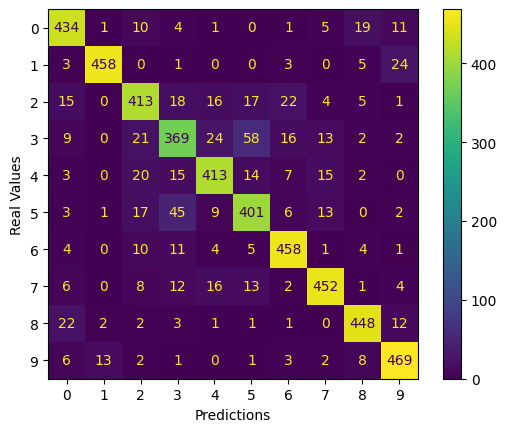

In [8]:
validate_model(simple_net_model)

***
### Modelo ResNet-18


Validation loss: 0.002693089810013771	Accuracy: 0.8958
Precision = 0.8960024014504967
Recall = 0.8958
F1 Score = 0.8952536718985028


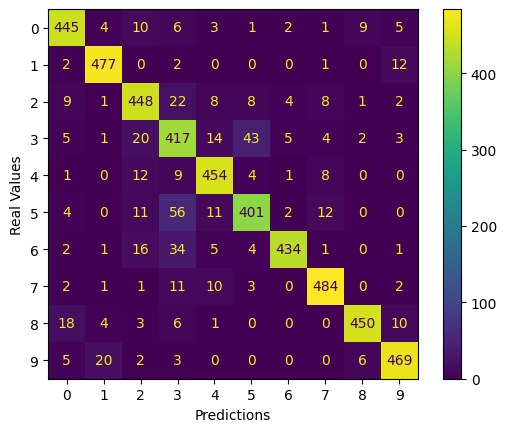

In [9]:
validate_model(res_net_model)

***
***
## Validación con Imagenes Locales

Este código proporciona funcionalidades para mostrar imágenes junto con sus etiquetas predichas y reales utilizando un modelo de clasificación de imágenes. También incluye una clase personalizada para manipular la asignación de clases a índices en un conjunto de datos de imágenes.

In [10]:
def get_labels(expected_values: torch.Tensor, predicted_values: torch.Tensor):
    classes: dict[int, str] = dict(map(reversed, train_set.class_to_idx.items()))  # type: ignore
    return [
        f"R: {classes[x]}\nP: {classes[y]}"
        for x, y in zip(expected_values.tolist(), predicted_values.tolist())
    ]


def imshow(
    tensor: torch.Tensor,
    labels: list[str],
):
    MAX_NCOLS = 8
    FONT_STYLE = dict(color="darkred", weight="bold", size=5)

    batch_size = tensor.size(0)

    ncols = min(MAX_NCOLS, batch_size)
    nrows = ceil(batch_size / MAX_NCOLS)

    _, axs = plt.subplots(nrows, ncols)

    k = 0
    for row in range(nrows):
        for col in range(ncols):
            ax: plt.Axes
            if nrows == 1:
                ax = axs[col]
            else:
                ax = axs[row, col]

            ax.axis("off")
            if k < batch_size:
                ax.set_title(labels[k], fontdict=FONT_STYLE, loc="left")

                img = tensor[k] / 2 + 0.5

                npimg = img.numpy()
                npimg = np.transpose(npimg, (1, 2, 0))

                ax.imshow(npimg, interpolation="nearest")

                k = k + 1
    plt.show()


class CustomImageFolder(torchvision.datasets.ImageFolder):
    def find_classes(self, directory: str) -> Tuple[List[str], Dict[str, int]]:
        class_to_idx = {
            "cat": 3,
            "dog": 5,
            "airplane": 0,
            "automobile": 1,
            "bird": 2,
            "deer": 4,
            "frog": 6,
            "horse": 7,
            "ship": 8,
            "truck": 9,
        }
        classes = list(class_to_idx.keys())
        return classes, class_to_idx


custom_set = CustomImageFolder(root="./assets/images", transform=test_transform)
custom_loader = DataLoader(custom_set, batch_size=32)


def custom_validate(model: Cifar10Model):
    for batch in custom_loader:
        images, labels = batch
        batch_step = model.batch_step(batch)

        imshow(images, get_labels(labels, batch_step["preds"]))

***
### Modelo SimpleNet

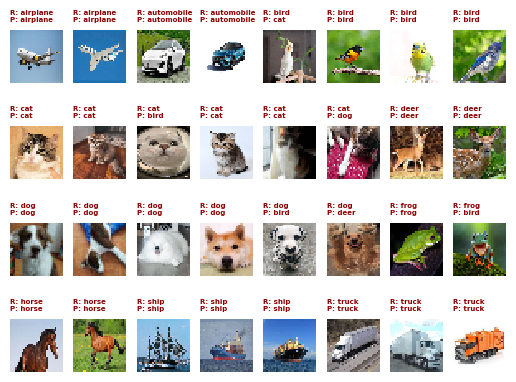

In [11]:
custom_validate(simple_net_model)

***
### Modelo ResNet-18

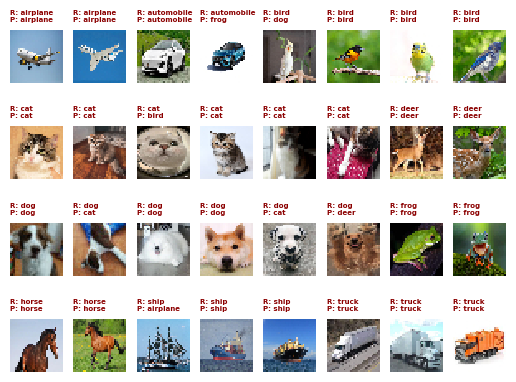

In [12]:
custom_validate(res_net_model)

***
***
***